In [1]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [2]:
path = 'sonido-presion/'
files = {i: {'presion': [], 'sonido': []} for i in range(1,4)}

for i,file in enumerate(os.listdir(path)):
  file_name = str(os.path.splitext(file)[0])
  segmento = int(file_name.split('_')[2])
  param = file_name.split('_')[0]

  sample_rate, data = wavfile.read(os.path.join(path, file))
  print(f'La frecuencia de muestreo del segmento {segmento} de {file_name.split("_")[0]} es {sample_rate}. N = {len(data)}')
  files[segmento][param] = data.astype(np.int32)

La frecuencia de muestreo del segmento 1 de beta es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de beta es 44150. N = 43401
La frecuencia de muestreo del segmento 3 de beta es 44150. N = 24473
La frecuencia de muestreo del segmento 1 de presion es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de presion es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de presion es 44150. N = 24472
La frecuencia de muestreo del segmento 1 de simulacion es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de simulacion es 44150. N = 43401
La frecuencia de muestreo del segmento 3 de simulacion es 44150. N = 24473
La frecuencia de muestreo del segmento 1 de sonido es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de sonido es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de sonido es 44150. N = 24472


In [3]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [4]:
#preguntar las ci !!!
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0

# Segmento 3

In [5]:
frec_m = 44150
dt_m = 1/frec_m
N  = len(files[3]['presion'])
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.5542695356738392 s


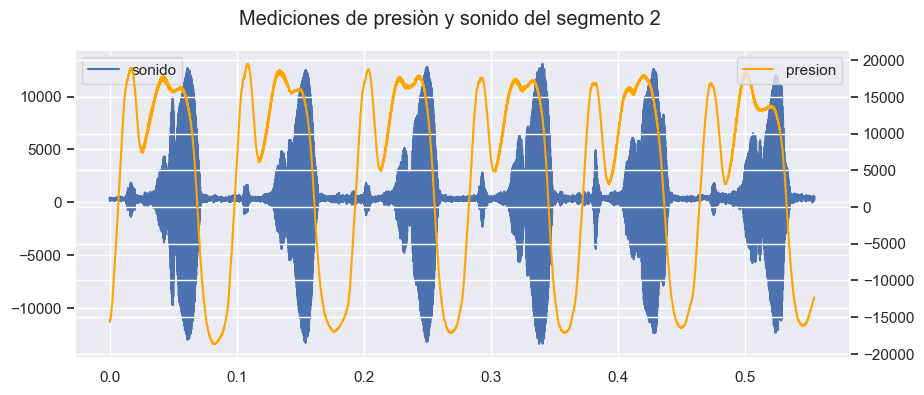

In [7]:


fig,ax = plt.subplots(figsize=(10,4))

ax.plot(t_m,files[3]['sonido'], label = 'sonido')
plt.suptitle('Mediciones de presiòn y sonido del segmento 2')
plt.legend(loc = 0)

ax2=ax.twinx()
ax2.tick_params(axis='both')
ax2.plot(t_m,files[3]['presion'], label = 'presion', color = 'orange')
plt.legend(loc= 1)
plt.show()


In [8]:
#dt = 1/884000
dt = dt_m / 20
t = np.arange(0, t_m[-1] + dt_m, dt)

In [9]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')
len(t)

N de la simulacion: 489441 
 N de los datos 24472 
  Tomo de la simulación 1 dato cada 20.000040863027134


489441

Interpolo $\beta$

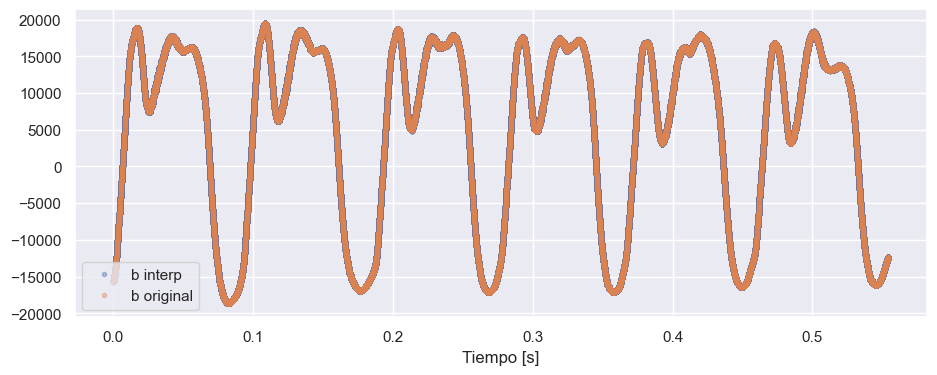

In [10]:
from scipy.interpolate import interp1d

p = files[3]['presion']
s = files[3]['sonido']

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))
plt.figure(figsize= (11,4))
plt.plot(t,b_interpolado, '.', label = "b interp", alpha = .4)
plt.plot(t_m, p, '.', label = "b original", alpha = .4)
plt.xlabel('Tiempo [s]')
plt.legend()
plt.show()

In [11]:
## NORMALIZO!!!! (primero normalizo, luego calculo el offset)
p = p/max(p)

#### Determino el offset $\beta = p + offset$ tal que los valores de $\beta$ sean negativos cuando el sonido es nulo

In [12]:

def plot1(offset):
    fig,ax = plt.subplots(figsize=(12,5))

    b = p + offset
    ax.plot(t_m,s, label = 'sonido', color = 'blue')
    ax.plot(t_m[b<0],s[b<0],'.', color = 'red')
    ax.plot()
    plt.legend(loc = 0)

    ax2=ax.twinx()
    ax2.tick_params(axis='both')
    ax2.plot(t_m,b, label = "presion")
    ax2.plot(t_m[b<0],b[b<0], color = 'red')
    ax2.axhline(y=0, color='black', linestyle='-')

    plt.legend(loc=1)
    plt.show()

#params
offset = widgets.FloatSlider(value=0.444 , min= 0.2 , max= 0.7, step= 1e-4, description='offset')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'offset': offset})

# muestro los outputs#
display(offset, output1)


FloatSlider(value=0.444, description='offset', max=0.7, min=0.2, step=0.0001)

Output()

In [13]:
## offset segmento 2 :
offset = 0.56

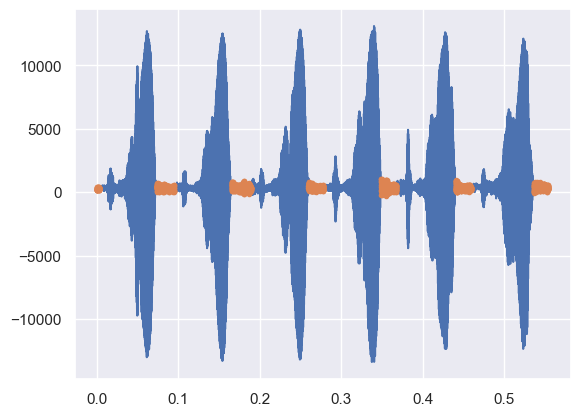

In [14]:
plt.plot(t_m[(p + offset)>0],s[(p + offset)>0])
plt.plot(t_m[(p + offset)<0],s[(p + offset)<0], '.')


Desviación estandar de la señal de sonido: 0.011691617186864118 


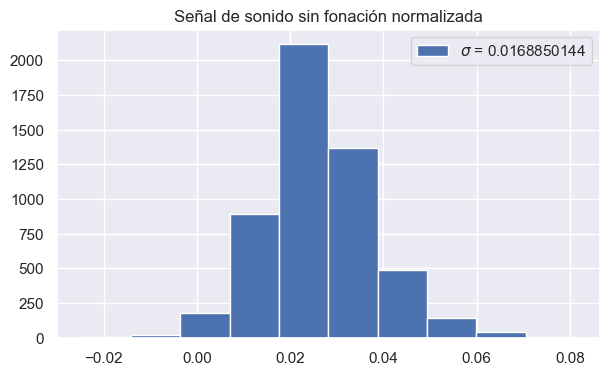

In [15]:
#sigma del sonido
sigma_s = np.std(s[(p + offset)<0]/max(s))

print(f'Desviación estandar de la señal de sonido: {sigma_s} ')
plt.figure(figsize=(7,4))
plt.title('Señal de sonido sin fonación normalizada')
plt.hist(s[(p + offset)<0]/max(s), label = r'$\sigma$ = ' + str(np.round(np.std(s[(p + 0.33)<0]/max(s)),10) ), bins = 10)
plt.legend()
plt.show() 

### Con $\beta$ interpolado ahora corro la simulación.

In [19]:
ruido = np.random.normal(0, sigma_s, len(t))


colors = ['green','red','black','blue']
N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración
for j in range(N_i):
    params = [k, c, f0 + ruido[j]*10, b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

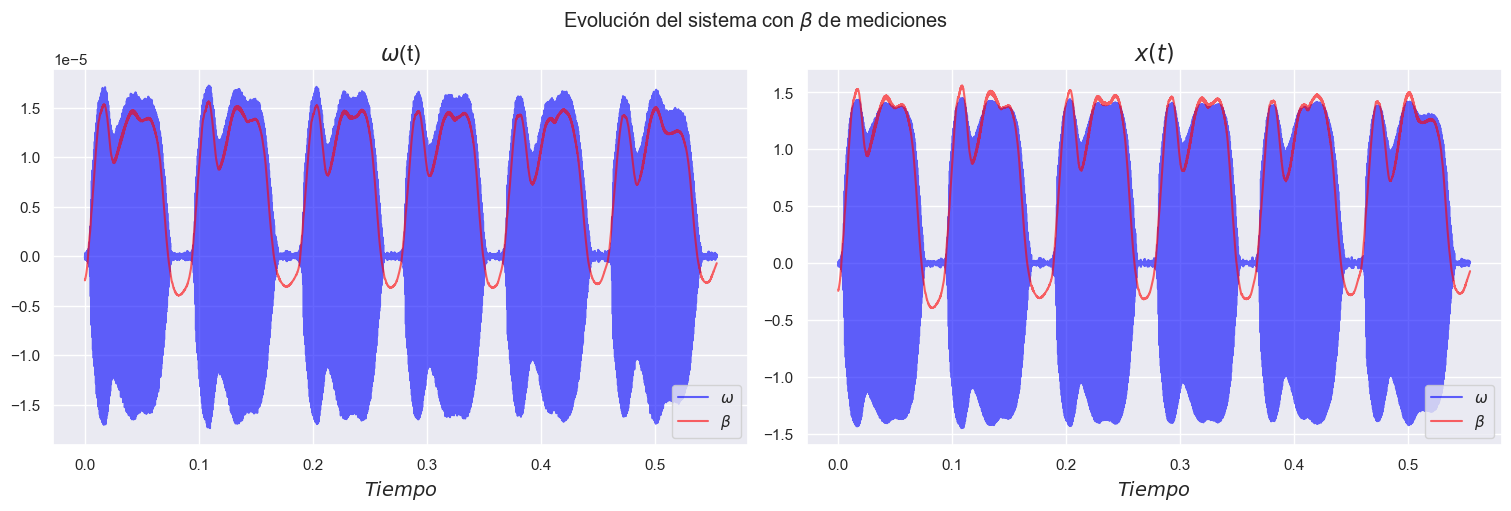

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True,
                                sharey=False)
#ploteo
ax1.plot(t,Xs[:,0][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax1.plot(t,b_*1e-5,alpha = .60, color=colors[1], label = r'$\beta$')
ax1.legend(loc=0)

ax2.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax2.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
ax2. legend(loc=0)

ax1.set_xlabel('$Tiempo$', fontsize=14)
ax1.set_title(r'$\omega$(t)', fontsize=16)
ax2.set_xlabel('$Tiempo$', fontsize=14)
ax2.set_title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

In [21]:
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')

N de la simulacion: 489441 
 N de los datos 24472 
  Tomo de la simulación 1 dato cada 20.000040863027134


In [22]:
#t_ = [t[i] for i in range(len(t)) if i % 20 == 0]
t_s = np.array([])
s_s = np.array([])
b_s = np.array([])

s_sim = Xs[:,1]

for i in range(len(t)):
  if i % 20 == 0:
    t_s = np.append(t_s, t[i])
    s_s = np.append(s_s, s_sim[i])
    b_s = np.append(b_s, b_[i])
#t_s = np.array(t_s[:len(t_m)]) #esto lo hago por el desfasaje de los dts!!! 
#s_s = np.array(s_s[:len(t_m)])

s_m = s/max(s) * max(s_s) # escaleo para que quede proporcional a las simulaciones
print(len(t_s), len(s_s), len(t_m), len(s_m))

24473 24473 24472 24472


En limpio las variables me quedaron:
t_s, t_m y s_s, s_m

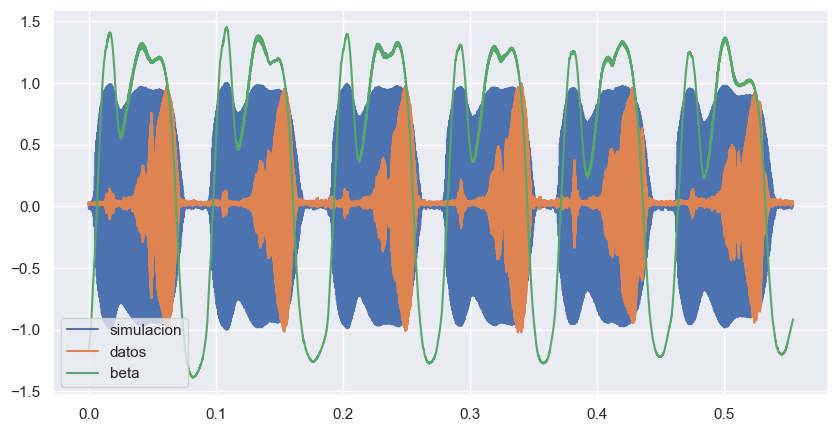

In [23]:


plt.figure(figsize=(10,5))
plt.plot(t_s,s_s/max(s_s), label = 'simulacion')
plt.plot(t_m,s_m/max(s_m), label = 'datos')
plt.plot(t_m, p/max(p)*max(s_s), label = 'beta')
#plt.plot(t_m,s_m-s_s,alpha = 0.4, label = 'diferencia') #sospecho que la diferencia es muy grande 
plt.legend()



Estudiar la envolvente en otro momento

GUARDO LOS ARCHIVOS

In [24]:
# guardo en un archivo la simulación}

wavfile.write("sonido-presion/simulacion_segmento_3.wav", frec_m, s_s.astype(np.float32))
wavfile.write("sonido-presion/beta_segmento_3.wav", frec_m, b_s.astype(np.float32)) #guardo el beta que use en la simulacion para comparar!!

In [62]:
type(files[1]['presion'])

numpy.ndarray